# Kaggle - Quora Question Pairs

https://www.kaggle.com/c/quora-question-pairs/data

In [10]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for train test split
from sklearn.model_selection import train_test_split

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [11]:
# Set Random Seed
np.random.seed(0)

In [12]:
# Import train and test datasets
train_all = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print train_all.shape
print test.shape

(404290, 6)
(2345796, 3)


In [13]:
# Make ID column index of dataframes
train_all = train_all.set_index(['id'])
test = test.set_index(['test_id'])
print ""

In [14]:
# Show example of non-duplicate questions
train_all.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [15]:
# Show example of duplicate questions
train_all.loc[train_all['is_duplicate']==1].head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [16]:
# Percent of train that is duplicate
dup_count = train_all.loc[train_all['is_duplicate']==1].shape[0]
tot_count = train_all.shape[0]
print "Percent of training set that are duplicates:"
print round(float(dup_count)/tot_count * 100, 2)

Percent of training set that are duplicates:
36.92


In [17]:
test.head()

,question1,question2
test_id,,
0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,What but is the best way to send money from Ch...,What you send money to China?
3,Which food not emulsifiers?,What foods fibre?
4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [25]:
X = train_all.ix[:,:4]
y = train_all.ix[:,4:]
print X.shape
print y.shape

(404290, 4)
(404290, 1)


# Train/Dev Split

In [26]:
# Split train into true train and dev set
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.1)
print X_train.shape
print X_dev.shape
print y_train.shape
print y_dev.shape

(363861, 4)
(40429, 4)
(363861, 1)
(40429, 1)


In [27]:
X_train['question1'].head()

id
58177     Has anyone found a way to make money using Quora?
349804                    How can I make ice cream project?
116959    How can I get rid of the memories of my ex-gir...
282272        What are all the types of chemical reactions?
342620                           How is the Credit Sudhaar?
Name: question1, dtype: object

# First Try using Levenshtein Distance

In [28]:
import editdistance

editdistance.eval('banana', 'bahama')

2L

In [29]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

Test similar function between examples to see what scores they get. I don't think this is going to work

In [34]:
print X_train.iloc[2]['question1']
print X_train.iloc[2]['question2']
print y_train.iloc[2]['is_duplicate']

How can I get rid of the memories of my ex-girlfriend when she is still around me?
How can I get rid of the memories of my ex- girlfriend?
0


In [36]:
editdistance.eval(X_train.iloc[2]['question1'], X_train.iloc[2]['question2'])

29L

In [37]:
print X_train.iloc[3]['question1']
print X_train.iloc[3]['question2']
print y_train.iloc[3]['is_duplicate']

What are all the types of chemical reactions?
What are the five types of chemical reactions?
1


In [38]:
editdistance.eval(X_train.iloc[3]['question1'], X_train.iloc[3]['question2'])

6L

In [45]:
X_train_lev = X_train.copy()
X_train_lev.head()

,qid1,qid2,question1,question2
id,,,,
58177,102110,12426,Has anyone found a way to make money using Quora?,How can I earn money through Quora?
349804,418224,478500,How can I make ice cream project?,How do you make ice cream from scratch?
116959,190422,190423,How can I get rid of the memories of my ex-gir...,How can I get rid of the memories of my ex- gi...
282272,402176,402177,What are all the types of chemical reactions?,What are the five types of chemical reactions?
342620,470616,470617,How is the Credit Sudhaar?,What is Credit Sudhaar?


In [47]:
def lev_dist(q1, q2):
    return editdistance.eval(q1, q2)

X_train_lev['Lev Distance'] = X_train_lev.apply(lambda row: lev_dist(row['question1'], row['question2']), axis=1)

Exception TypeError: "object of type 'float' has no len()" in 'editdistance.bycython.eval' ignored
Exception TypeError: "object of type 'float' has no len()" in 'editdistance.bycython.eval' ignored


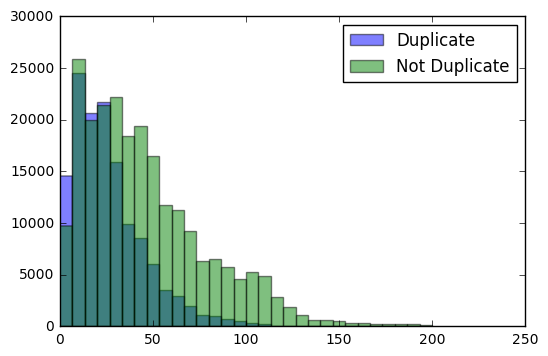

In [85]:
plt.clf
plt.hist(X_train_lev.loc[y_train['is_duplicate']==1]['Lev Distance'], bins=30, alpha=0.5, label='Duplicate', range=(0,200))
plt.hist(X_train_lev.loc[y_train['is_duplicate']==0]['Lev Distance'], bins=30, alpha=0.5, label='Not Duplicate', range=(0,200))
plt.legend(loc='upper right')

# Pull in DBgriffs code

In [95]:
# based off of code from following kernel https://www.kaggle.com/anokas/quora-question-pairs/data-analysis-xgboost-starter-0-35460-lb

import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
from nltk.corpus import stopwords
from collections import Counter

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0

    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]

    R = np.sum(shared_weights) / np.sum(total_weights)
    return R



df_train['word_match'] = df_train.apply(word_match_share, axis=1, raw=True)
df_train['tfidf_word_match'] = df_train.apply(tfidf_word_match_share, axis=1, raw=True)

df_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
df_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

df_train.to_csv('./features/test_word_match.csv', index = False)
df_test.to_csv('./features/train_word_match.csv', index = False)


/Users/robmulla/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in long_scalars
/Users/robmulla/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in double_scalars


In [96]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,word_match,tfidf_word_match
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0,0.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0,0.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0,0.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0,NaN
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0,NaN


# Other stuff

In [140]:
train_vector = CountVectorizer()
x = train_vector.fit_transform(X_train['question1'].values.astype('U'))

In [133]:
# Train a logistic regression model using a "l1" penalty. 
train_vector = CountVectorizer()
X_train_matrix = train_vector.fit_transform(X_train['question1'].values.astype('U'))

In [106]:
# Setup TFIDF vector and transformed data
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train)
X_dev_tfidf = tfidf.transform(X_dev)

print X_tfidf.shape
print X_tfidf
print y_train.shape
print X_dev_tfidf

# Create logistic Regression model with C=100
lr = LogisticRegression() 
lr.fit(X_tfidf, y_train)
tfidf_preds = lr.predict(X_dev_tfidf)

# Find and print score
f1 = metrics.f1_score(y_true = y_dev, y_pred = tfidf_preds, average='weighted')
print "The f1 score using TfidfVectorizer: " + str(f1)


(5, 5)
  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
(363861, 1)
  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0


ValueError: Found input variables with inconsistent numbers of samples: [5, 363861]